In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat 

import torch
import torch.nn as nn

In [2]:
from kspace_handling_functions import ifftnd,fftnd,rms_comb,do_image,plot_pair
from plotting_functions import *
from kspace_handling_functions import normalize_image,normalize_kspace_max,normalize_kspace_z,norm_dataset
from data_transformation_and_augmentation import *

In [3]:
from kornia.losses import SSIMLoss,MS_SSIMLoss
class MixedLoss(nn.Module):
    def __init__(self, beta=0.1, weight=None, size_average=True,SSIM_flag=False):
        super(MixedLoss, self).__init__()
        
        self.pool2D=torch.nn.AvgPool2d([1,2],stride=[1,2],divisor_override=2)
        
        self.MSEloss = nn.MSELoss()
        
        if SSIM_flag == True :
            self.im_loss = MS_SSIMLoss()
            
        else:
            self.im_loss = nn.MSELoss()
            
        
        
        self.beta=beta
        
 
    def forward(self, k_pred,im_pred, targets):     
        
        z = self.pool2D(targets)# subsample
        z = torch.complex(z[:,0,:,:], z[:,1,:,:])
        #print(z.dtype)
        z = torch.unsqueeze(z,dim=1)
        #print(z.dtype)
        im = torch.fft.fftshift( torch.fft.ifft2( torch.fft.ifftshift(z,dim=[-2,-1] ),norm="ortho" ),dim=[-2,-1]).abs()

        
        #im=torch.nn.functional.normalize(im, p=2.0, dim=[0])# normalized GT image # controllare se va messo
        #im_pred=torch.nn.functional.normalize(im_pred, p=2.0, dim=[0])# normalized prediction
        
        im_loss = self.im_loss(im_pred, im)
        
        k_loss = self.MSEloss(k_pred,targets)
        
        return (1-self.beta)*k_loss + self.beta*im_loss

In [4]:
!pip install dipy

In [5]:
from time import time
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma


In [9]:
Immagine = "/workspace/data/long_images_averaged.npz"

In [10]:
def load_data_fede(file):
    with np.load(file) as data:
        kspace = data["k_space_list"]
        images = data["image_list"]
        final_image = data["final_im"]
        final_k = data["final_k"]
        return kspace,images,final_image,final_k

In [14]:
kspace,images,final_image,k_data = load_data_fede(Immagine)

In [15]:
k_data.shape

(13, 96, 1, 256)

In [13]:
final_image.shape

(13, 96, 256)

In [ ]:
def normM(M0):
    '''float norm tra 0.1'''
    
#    M0 = M0.numpy()
    M0 = (M0-np.min(M0))/(np.max(M0)-np.min(M0))
    return M0

In [16]:
#k_data = loadmat(Immagine)['ans']# output di scipy.io is a dictionary "ans" select the numerical data
#imm = loadmat(Immagine)# output di scipy.io is a dictionary "ans" select the numerical data
k_data=np.transpose(k_data,(0,2,1,3))
#k_data = np.expand_dims(k_data,axis=1)

k_data=normalize_kspace_max(k_data)

In [17]:
k_data.shape

(13, 1, 96, 256)

# transform data so it is similar to the taining data

In [18]:
sp = list(k_data.shape)
sp[1]=2
nn_input = torch.zeros(sp)
tt = ToTensor()
for i,k in enumerate(k_data):
    nn_input[i,:] = tt(k)

In [19]:
nn_input.shape

torch.Size([13, 2, 96, 256])

In [20]:
from models import *
#model = DnCNN(2,num_of_layers=model_params["layers"],features = 32)
model = BRDNet()
# move the model into the GPU
model.to('cpu')
_ = model.load_state_dict(torch.load("new_model_exampe_normalized_beta05.pth")['model_state_dict'])
model.eval()

BRDNet(
  (upnet): UpNet(
    (net): Sequential(
      (0): Conv2d(2, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (1): BatchRenorm2d()
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (4): BatchRenorm2d()
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (7): BatchRenorm2d()
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (10): BatchRenorm2d()
      (11): ReLU()
      (12): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (13): BatchRenorm2d()
      (14): ReLU()
      (15): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (16): BatchRenorm2d()
      (17): ReLU()
      (18): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (19): BatchRenorm2d()
      (20): ReLU()
      (21): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (22

In [21]:
pred_k, pred_im = model(nn_input)

In [22]:
pred_im.shape

torch.Size([13, 1, 96, 128])

In [36]:
def show_generator_output(k_batch, pred_im):
    """Show image with landmarks for a batch of samples."""
    
    
    # convert them to numpy and then to complex so they can be used with do_image
    k_batch = k_batch.detach().numpy()
    pred_im = pred_im.detach().numpy()
    pred_im = np.squeeze(pred_im)
    
    # to complex 
    k_batch = k_batch[:,0,:,:] + 1j*k_batch[:,1,:,:]
   
    
    
    images_batch = do_image(k_batch)  
    #label_batch = do_image(k_label_batch) 
    
    sigma = estimate_sigma(images_batch, N=1)# questo metodo ha bisogno di una stima di sigma del noise per funzionare
    den = nlmeans(images_batch, sigma=sigma, patch_radius=3,
              block_radius=4, rician=True)
    
    print(images_batch.shape)
    print(den.shape)
    
    batch_size = len(images_batch)
    print(batch_size)
    if batch_size > 12:
        batch_size = 12
    im_size = images_batch.shape[2:3]
    

    f,axes = plt.subplots(batch_size,3,figsize=(15,30))
    for i in range(batch_size):
        axes[i,0].imshow(images_batch[i],cmap="Greys_r")
        axes[i,0].set_title("Low SNR")
        axes[i,1].imshow(pred_im[i],cmap="Greys_r")
        axes[i,1].set_title("pred rete")
        axes[i,0].axis('off')
        #axes[i,0].ioff()
        axes[i,1].axis('off')
        #axes[i,1].ioff()
        axes[i,2].imshow(den[i],cmap="Greys_r")
        axes[i,2].set_title("NLM")
        axes[i,2].axis('off')

(13, 96, 128)
(13, 96, 128)
13


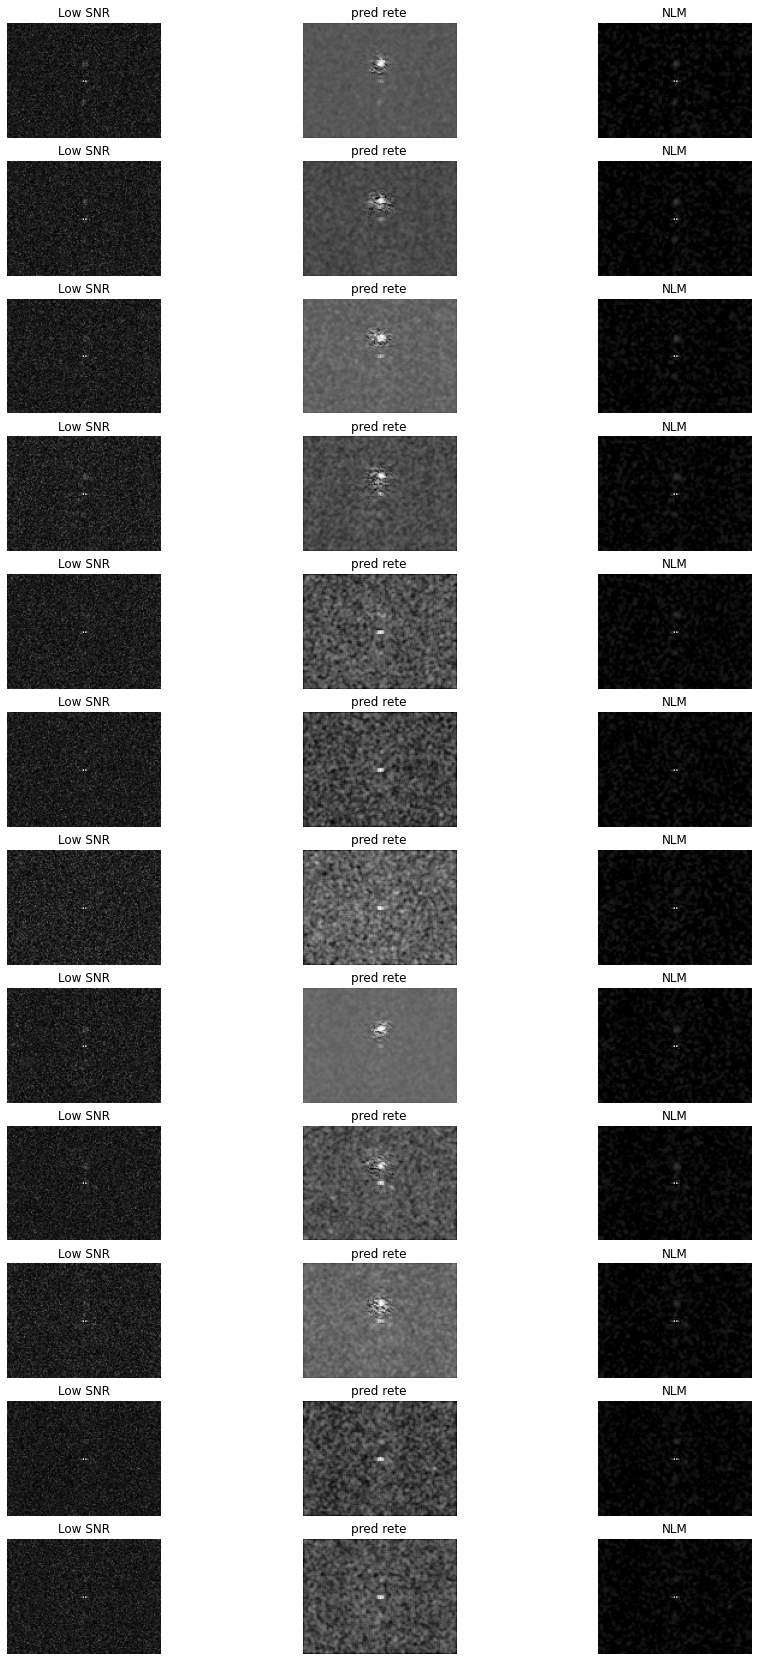

In [37]:
show_generator_output(nn_input,pred_im)

In [69]:

def histo(image_3_alist,range_fette = [60,68]):

    original, pred_rete, nlm = image_3_alist
    
    
  
    
    fmin,fmax = range_fette
    
    for fetta in range(original.shape[0]):
        # qui il lato corto è 96 quindi metà lato è 48 e il pixel è 2.5 mm
        # distribuzione delle intensita' lungo la coordinata x per le fette 7-8
        f,axes = plt.subplots(1,3,figsize=(30,5))
        axes[0].bar(np.arange(-48,48)*2.5,original[fetta,:,fmin:fmax].max(axis=1).ravel(),alpha=0.7,label="signal",width=2.5)
        axes[0].bar(np.arange(-48,48)*2.5,original[fetta,:,0:8].max(axis=1).ravel(),alpha=0.7,label="noise",width=2.5)
        axes[0].set_xlabel("mm")
        axes[0].legend()
        axes[0].set_title("original image (x profile)")
        
        axes[1].bar(np.arange(-48,48)*2.5,pred_rete[fetta,:,fmin:fmax].max(axis=1).ravel(),alpha=0.7,label="signal",width=2.5)
        axes[1].bar(np.arange(-48,48)*2.5,pred_rete[fetta,:,0:8].max(axis=1).ravel(),alpha=0.7,label="noise",width=2.5)
        axes[1].set_xlabel("mm")
        axes[1].legend()
        axes[1].set_title("DNN image (x profile)")
        
        axes[2].bar(np.arange(-48,48)*2.5,nlm[fetta,:,fmin:fmax].max(axis=1).ravel(),alpha=0.7,label="signal",width=2.5)
        axes[2].bar(np.arange(-48,48)*2.5,nlm[fetta,:,0:8].max(axis=1).ravel(),alpha=0.7,label="noise",width=2.5)
        axes[2].set_xlabel("mm")
        axes[2].legend()
        axes[2].set_title("NLM image (x profile)")

In [70]:
pred_im_np = pred_im.detach().numpy()
pred_im_np = np.squeeze(pred_im_np)

In [79]:
k_batch = nn_input.detach().numpy()

# to complex 
k_batch = k_batch[:,0,:,:] + 1j*k_batch[:,1,:,:]

images_batch = do_image(k_batch)  
#label_batch = do_image(k_label_batch) 

#for i in range(images_batch.shape[0]):
 #   images_batch[i,46:50,62:66] = 0# original[i].min()
    
    
for i in range(images_batch.shape[0]):
    px = images_batch[i].argmax()
    im_shape = images_batch[i].shape
    tmp = images_batch[i].reshape(-1) 
    tmp[px]=0
    images_batch[i] = tmp.reshape(im_shape)

sigma = estimate_sigma(images_batch, N=1)# questo metodo ha bisogno di una stima di sigma del noise per funzionare
den = nlmeans(images_batch, sigma=sigma, patch_radius=3,
          block_radius=4, rician=True)

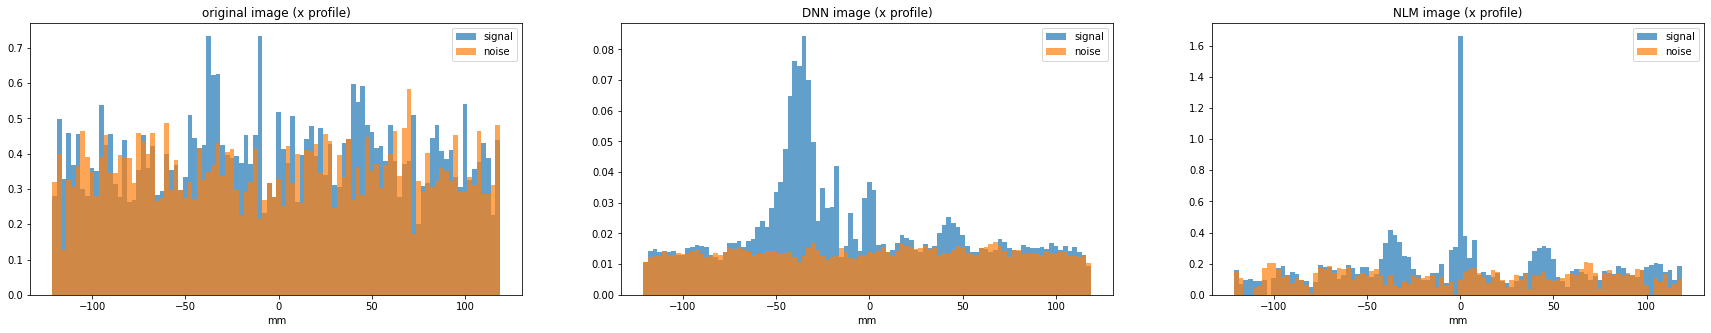

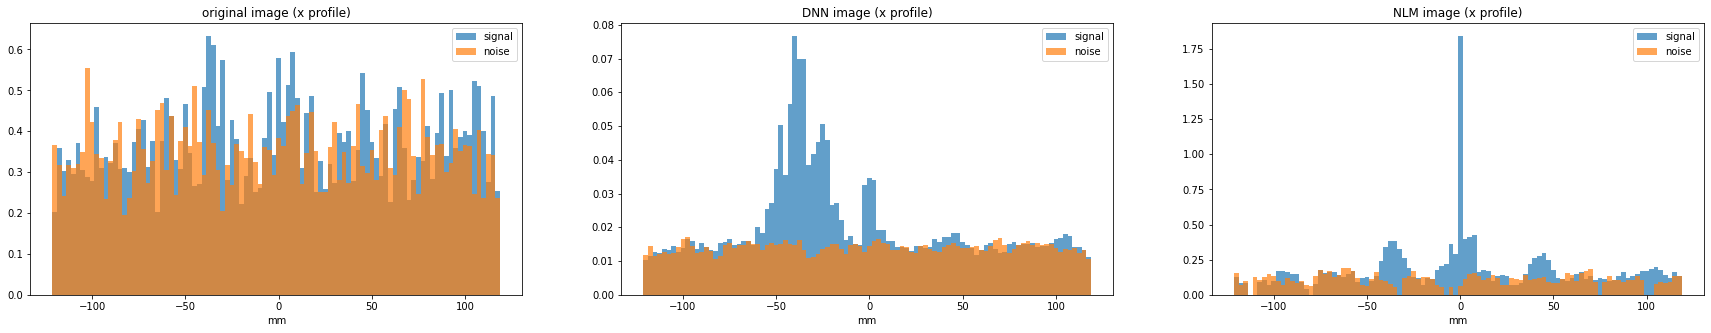

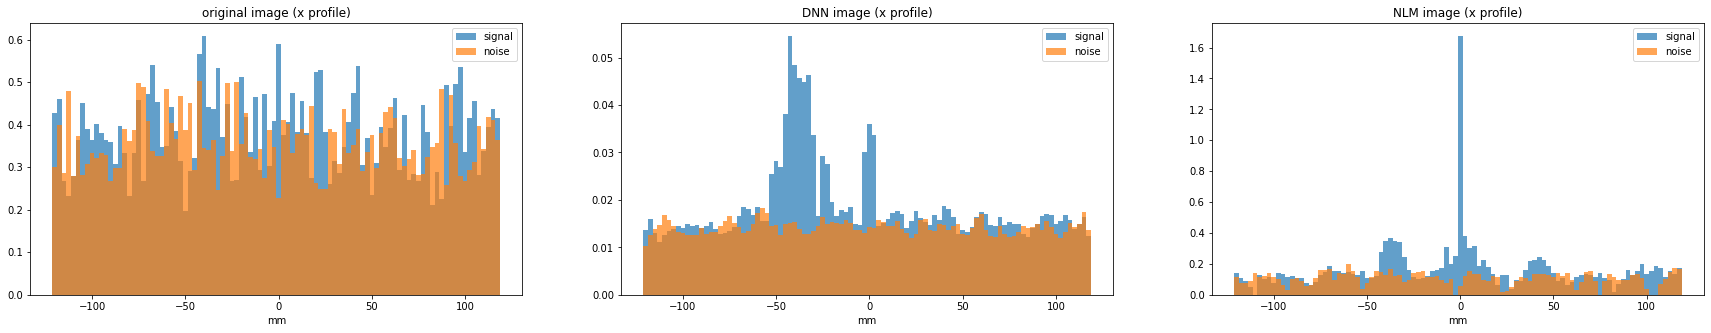

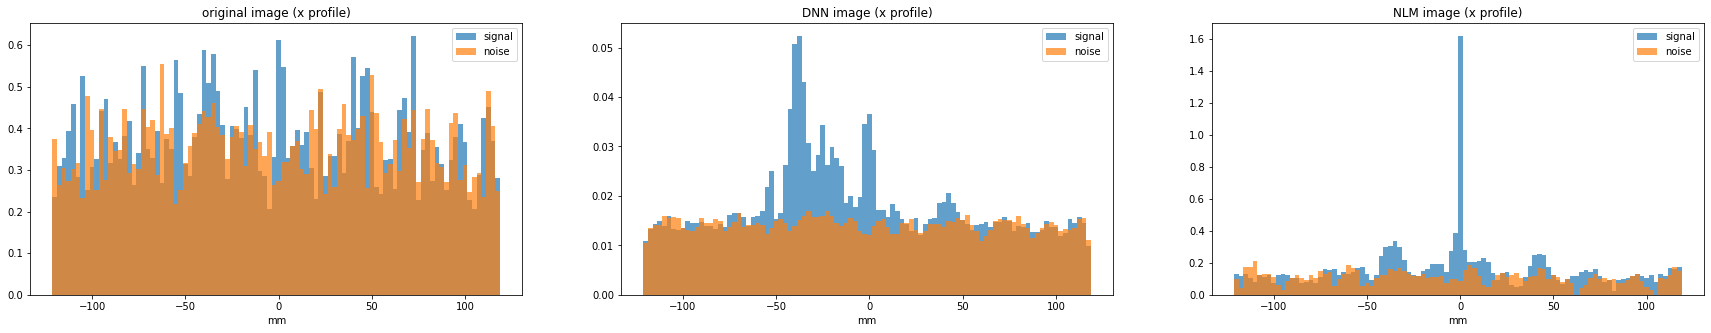

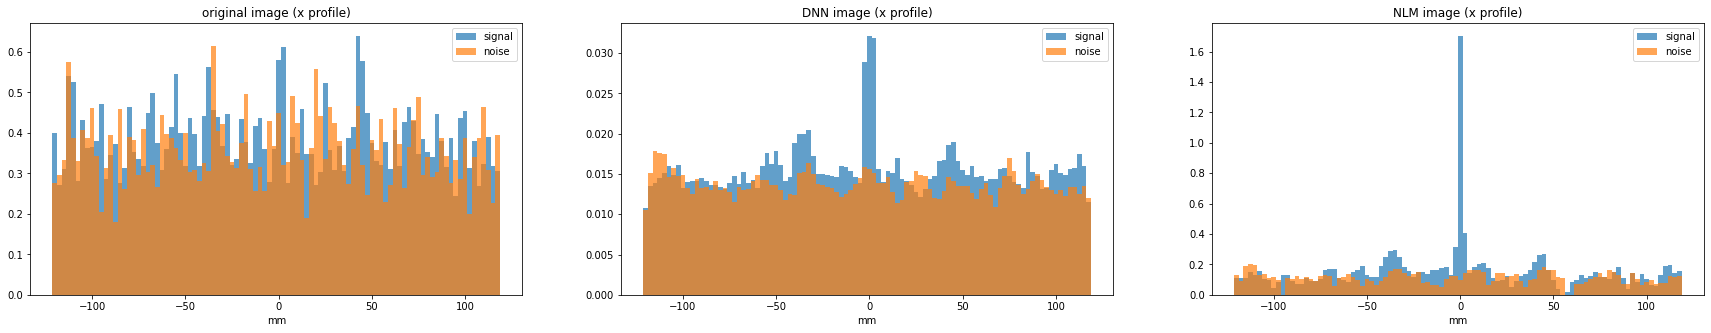

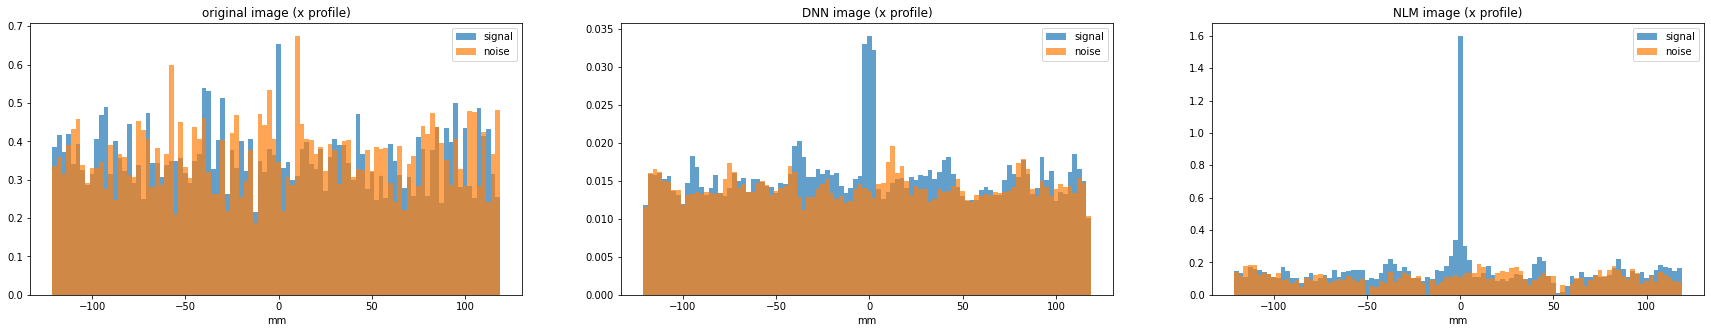

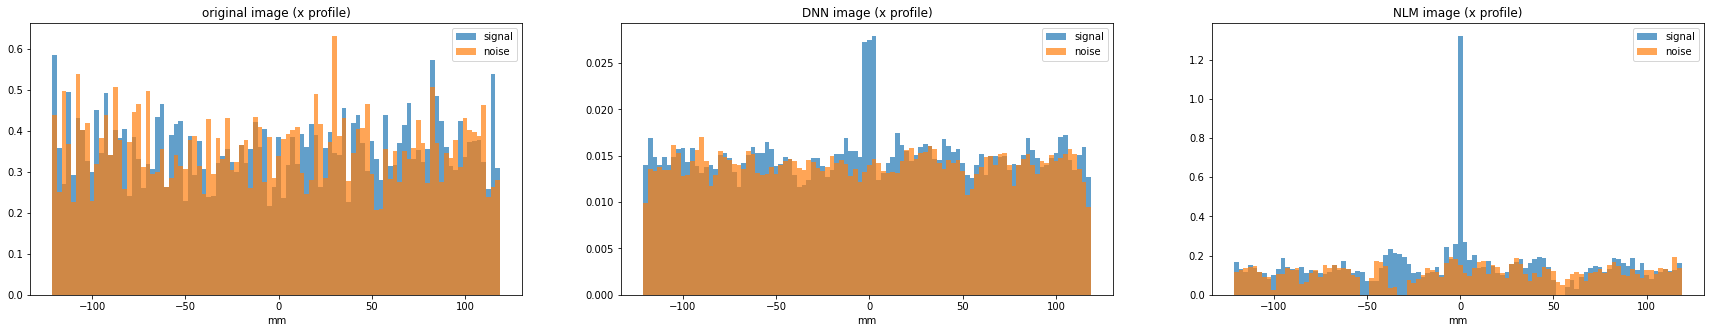

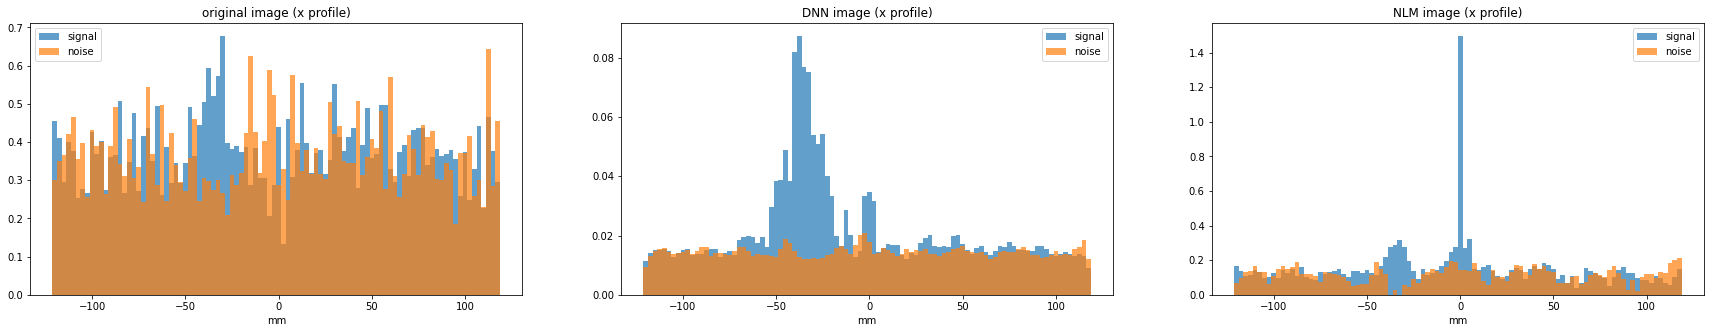

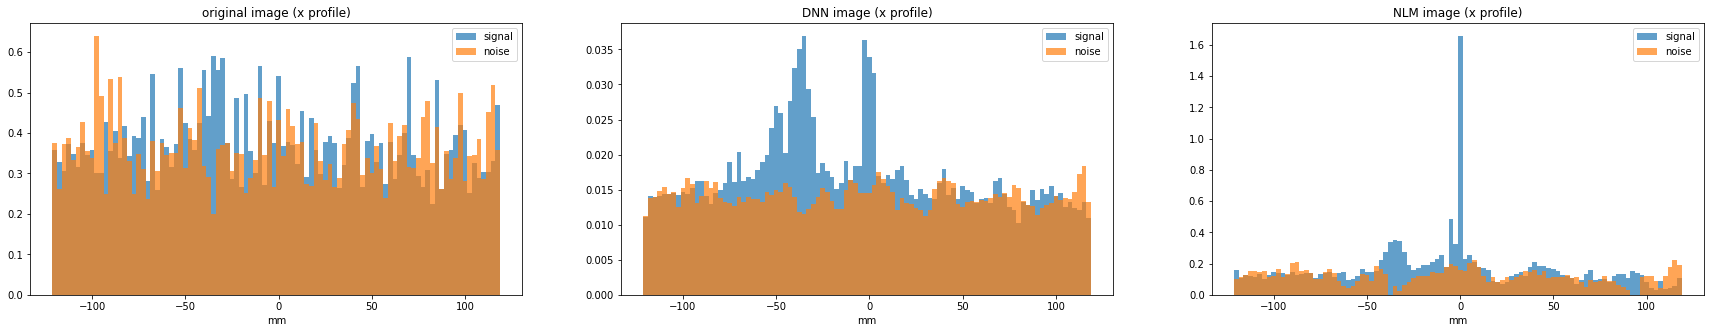

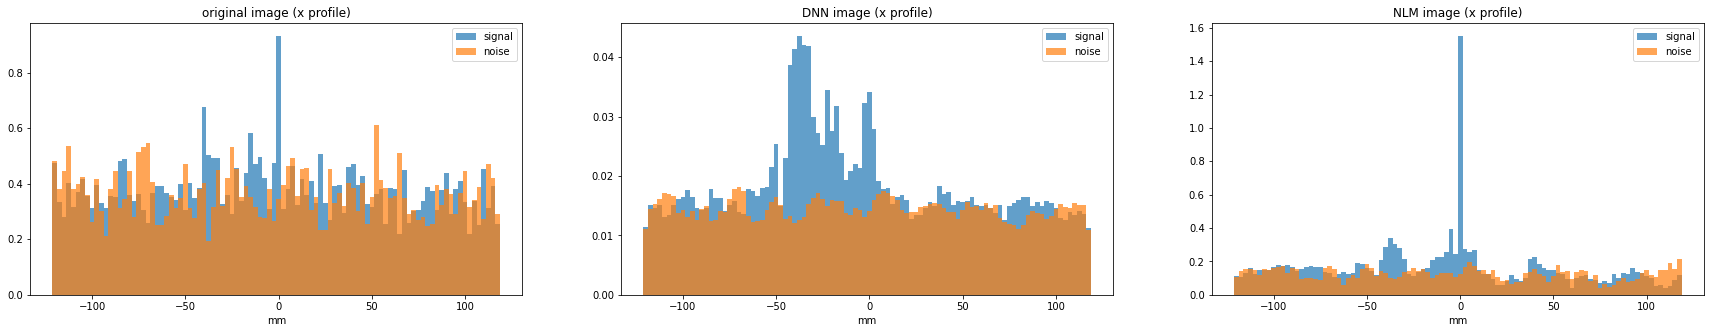

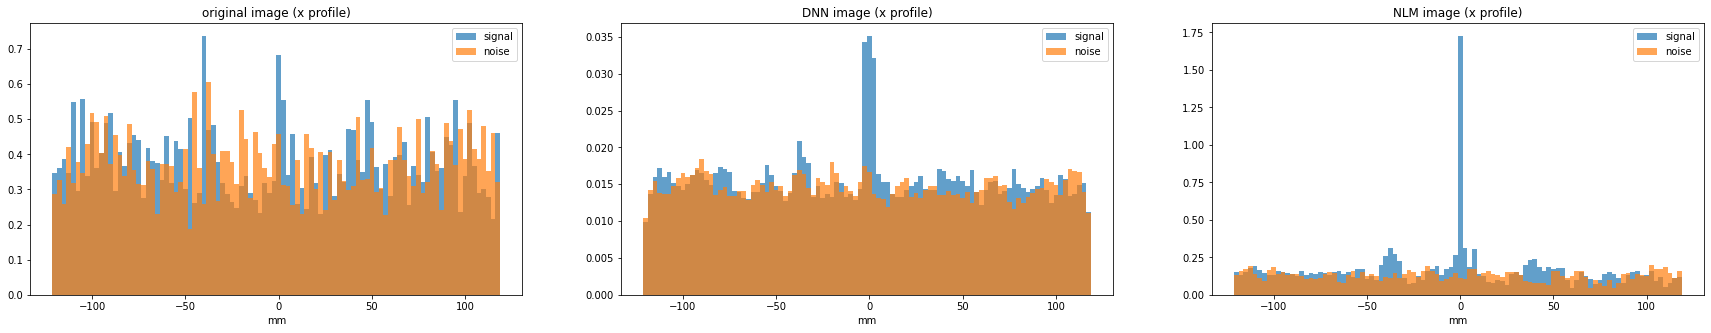

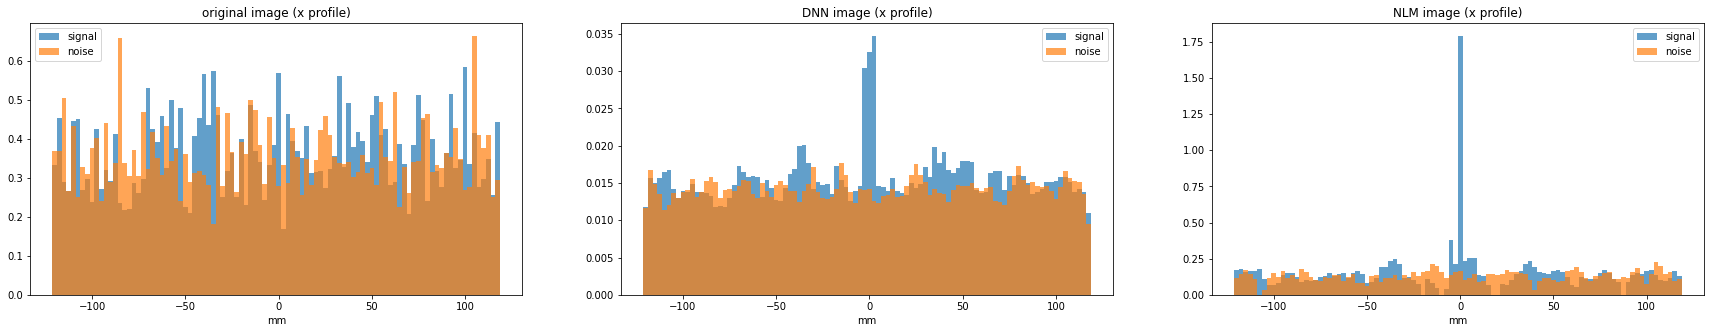

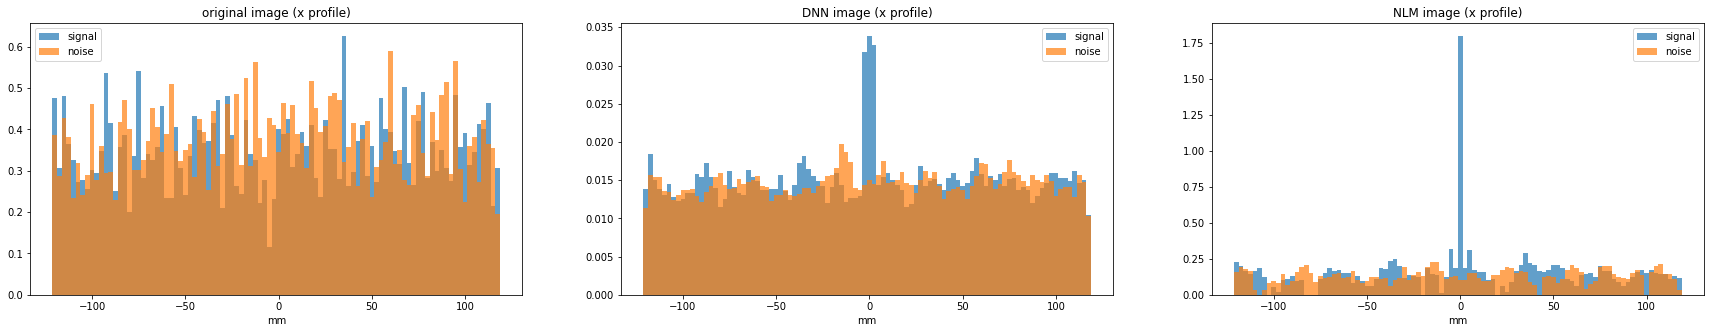

In [80]:
histo([images_batch,pred_im_np,den],range_fette = [60,68])